In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import ElasticNetCV

In [145]:
data = pd.read_csv(f'E:/ACTU/Applied Data Science/Project 4/Applied-Data-Science-Final-Project/data_imputed.csv')

In [146]:
# rename and generate sat ave for total ,math and reading seperately
# total ave
data['sat_avg'] = data[
    [
        'sat_critical_reading_25th_percentile_score',
        'sat_critical_reading_75th_percentile_score',
        'sat_math_25th_percentile_score',
        'sat_math_75th_percentile_score'
    ]
].mean(axis=1, skipna=True)
# act ave
data['act_ave']=data[
     ['act_composite_25th_percentile_score',
      'act_composite_75th_percentile_score'
     ]
].mean(axis=1,skipna=True)
# calculate yield and admission
data['calculated_yield'] = (
    data['admissions_total'] / data['admissions_total']
)
data['calculated_admission_rate'] = (
    data['enrolled_total'] / data['applicants_total']
)
#rename
data_rename = data.rename(columns={
    'name': 'inst_name',
    'percent_admitted__total': 'admission_rate',
    'admissions_yield__total': 'yield',
    'undergraduate_enrollment': 'ugds',
    'control_of_institution': 'control',
    'degree_of_urbanization_urbancentric_locale': 'locale',
    'tuition_and_fees_201314': 'tuitionfee_in',
    'total_price_for_outofstate_students_living_on_campus_201314': 'tuitionfee_out',
    'percent_of_total_enrollment_that_are_white': 'pct_white',
    'percent_of_total_enrollment_that_are_black_or_african_american': 'pct_black',
    'percent_of_total_enrollment_that_are_hispaniclatino': 'pct_hispanic',
    'percent_of_total_enrollment_that_are_asian': 'pct_asian'
})

In [147]:
#check unique value
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", categorical_cols)
cat_summary = pd.DataFrame({
    'n_unique': [data[col].nunique() for col in categorical_cols]
}, index=categorical_cols)

print(cat_summary.sort_values(by='n_unique'))

Categorical columns: ['name', 'zip_code', 'highest_degree_offered', 'county_name', 'religious_affiliation', 'offers_less_than_one_year_certificate', 'offers_one_but_less_than_two_years_certificate', 'offers_associates_degree', 'offers_two_but_less_than_4_years_certificate', 'offers_bachelors_degree', 'offers_postbaccalaureate_certificate', 'offers_masters_degree', 'offers_postmasters_certificate', 'offers_doctors_degree__researchscholarship', 'offers_doctors_degree__professional_practice', 'offers_doctors_degree__other', 'offers_other_degree', 'state_abbreviation', 'fips_state_code', 'geographic_region', 'sector_of_institution', 'level_of_institution', 'control_of_institution', 'historically_black_college_or_university', 'tribal_college', 'degree_of_urbanization_urbancentric_locale', 'carnegie_classification_2010_basic']
                                                n_unique
tribal_college                                         1
level_of_institution                                 

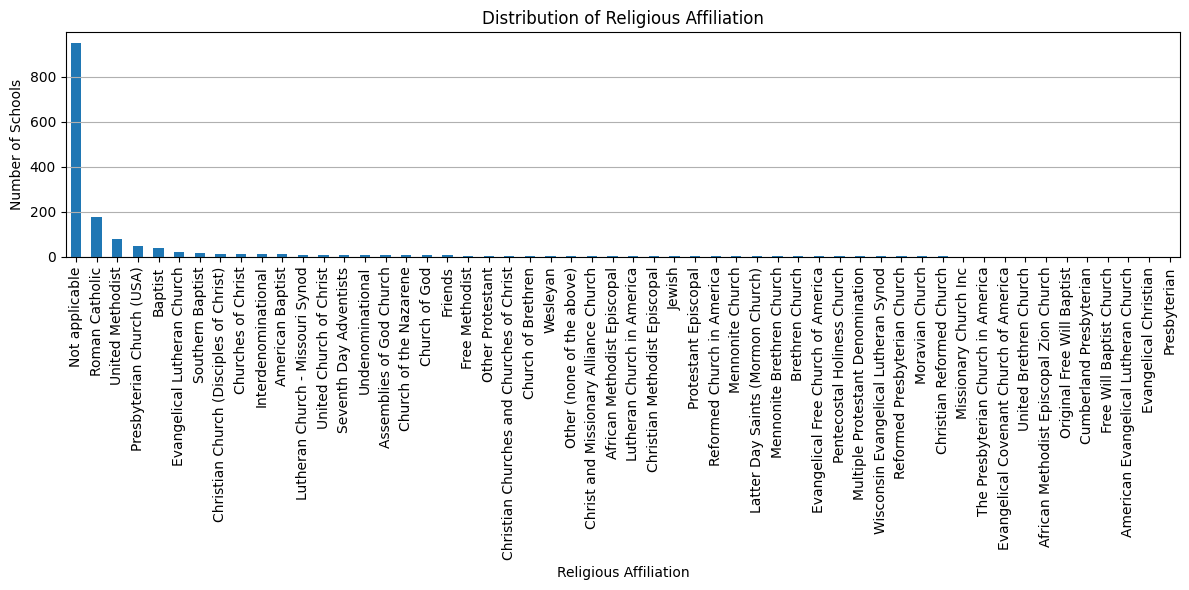

In [148]:
#check distribution of religious_affiliation
affiliation_counts = data['religious_affiliation'].value_counts(dropna=False)
plt.figure(figsize=(12,6))
affiliation_counts.plot(kind='bar')
plt.title('Distribution of Religious Affiliation')
plt.xlabel('Religious Affiliation')
plt.ylabel('Number of Schools')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [149]:
# feature engineering
# drop unnecessary variables and used variables
data_droped = data.drop(columns=[
    'tribal_college','level_of_institution','admissions_yield__total',
    'zip_code','county_name','state_abbreviation',
    'longitude_location_of_institution','latitude_location_of_institution','id_number','year','enrolled_total','admissions_total','applicants_total'
    ,'percent_admitted__total','admissions_yield__total','sat_critical_reading_25th_percentile_score','sat_critical_reading_75th_percentile_score',
    'sat_math_25th_percentile_score','sat_math_75th_percentile_score','act_composite_25th_percentile_score','act_composite_75th_percentile_score'
], errors='ignore')

# same name as list
school_names = data_droped[['name']].copy()

# binary encode (riligious keep top 5)
top5_affiliations = data_droped['religious_affiliation'].value_counts().nlargest(5).index.tolist()
data_droped['religious_affiliation_reduced'] = data_droped['religious_affiliation'].apply(
    lambda x: x if x in top5_affiliations else 'Other'
)
data_droped = data_droped.drop(columns=['religious_affiliation'])

# encode categorical variables by one hot
categorical_cols = data_droped.select_dtypes(include=['object', 'category']).columns.tolist() 
X_cat = data_droped[categorical_cols]
X_num = data_droped.drop(columns=categorical_cols)
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(X_cat)
encoded_col_names = encoder.get_feature_names_out(categorical_cols)
X_cat_encoded_df = pd.DataFrame(X_cat_encoded, columns=encoded_col_names, index=data_droped.index)
data_encoded = pd.concat([X_num, X_cat_encoded_df], axis=1)

# convert percent to float
percent_cols = [col for col in data_encoded.columns if 'percent_of_' in col]
data_encoded[percent_cols] = data_encoded[percent_cols] / 100.0

# standardize
numerical_cols = data_encoded.select_dtypes(include='number').columns.tolist()
# identify categorical cols
one_hot_cols = [col for col in data_encoded.columns if set(data_encoded[col].dropna().unique()).issubset({0, 1})]
cols_to_standardize = list(set(numerical_cols) - set(one_hot_cols))
scaler = StandardScaler()
data_encoded[cols_to_standardize] = scaler.fit_transform(data_encoded[cols_to_standardize])


final_data = pd.concat([school_names, data_encoded], axis=1)
final_data

,name,percent_of_freshmen_submitting_sat_scores,percent_of_freshmen_submitting_act_scores,estimated_enrollment_total,estimated_enrollment_full_time,estimated_enrollment_part_time,estimated_undergraduate_enrollment_total,estimated_undergraduate_enrollment_full_time,estimated_undergraduate_enrollment_part_time,estimated_freshman_undergraduate_enrollment_total,...,carnegie_classification_2010_basic_Master's Colleges and Universities (larger programs),carnegie_classification_2010_basic_Master's Colleges and Universities (medium programs),carnegie_classification_2010_basic_Master's Colleges and Universities (smaller programs),carnegie_classification_2010_basic_Research Universities (high research activity),carnegie_classification_2010_basic_Research Universities (very high research activity),religious_affiliation_reduced_Not applicable,religious_affiliation_reduced_Other,religious_affiliation_reduced_Presbyterian Church (USA),religious_affiliation_reduced_Roman Catholic,religious_affiliation_reduced_United Methodist
0,Alabama A & M University,-1.303242,1.241512,-0.213659,-0.123383,-0.377745,-0.202088,-0.117758,-0.360115,0.091043,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,University of Alabama at Birmingham,-1.589830,1.415653,1.230337,0.885345,1.711035,0.832930,0.639398,1.030232,0.619450,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,Amridge University,0.288913,-0.116790,-0.682553,-0.675575,-0.475510,-0.722169,-0.716170,-0.428382,-0.776207,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,University of Alabama in Huntsville,-0.698223,1.450482,0.037100,-0.075087,0.312852,0.025985,-0.045450,0.219677,-0.266757,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,Alabama State University,-1.207713,1.206684,-0.101500,-0.023973,-0.269926,-0.021130,0.060269,-0.249060,0.436996,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,University of South Florida-Sarasota-Manatee,0.734716,0.231492,-0.547898,-0.602191,-0.227284,-0.523977,-0.610949,-0.047142,-0.713019,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1530,The Kingâ€™s College,0.034168,-0.256104,-0.695560,-0.653707,-0.574316,-0.695623,-0.668463,-0.474535,-0.680636,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1531,Ottawa University-Online,0.288913,-0.116790,-0.701850,-0.719042,-0.425934,-0.712996,-0.749581,-0.300020,-0.772258,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1532,Providence Christian College,0.288913,-0.116790,-0.742044,-0.710187,-0.579516,-0.756220,-0.738444,-0.481746,-0.765149,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [151]:
# drop high correlation variables
cols_to_exclude = ['name','calculated_admission_rate']
data_for_corr = final_data.drop(columns=cols_to_exclude, errors='ignore')
numerical_data = data_for_corr.select_dtypes(include=[np.number])
continuous_data = numerical_data.drop(columns=one_hot_cols)
#correlation matrix
correlation_threshold = 0.85
to_drop = [col for col in upper.columns if any(upper[col] > correlation_threshold)]
print(to_drop)
final_data_cleaned = final_data.drop(columns=to_drop, errors='ignore')
final_data_cleaned = final_data.drop(columns=to_drop, errors='ignore')

['percent_of_freshmen_submitting_act_scores', 'estimated_enrollment_full_time', 'estimated_undergraduate_enrollment_total', 'estimated_undergraduate_enrollment_full_time', 'estimated_undergraduate_enrollment_part_time', 'estimated_freshman_undergraduate_enrollment_total', 'estimated_freshman_enrollment_full_time', 'estimated_graduate_enrollment_full_time', 'bachelors_degrees_awarded', 'masters_degrees_awarded', 'doctors_degrese__researchscholarship_awarded', 'number_of_students_receiving_an_associates_degree', 'number_of_students_receiving_a_bachelors_degree', 'number_of_students_receiving_a_masters_degree', 'number_of_students_receiving_a_doctors_degree', 'number_of_students_receiving_a_certificate_of_less_than_1year', 'tuition_and_fees_201112', 'tuition_and_fees_201213', 'tuition_and_fees_201314', 'total_price_for_instate_students_living_on_campus_201314', 'total_price_for_outofstate_students_living_on_campus_201314', 'total__enrollment', 'fulltime_enrollment', 'parttime_enrollment',

In [159]:
# selecet important feature by lasso regression
X = final_data_cleaned.drop(columns=['name', 'calculated_admission_rate'], errors='ignore')
y = final_data_cleaned['calculated_admission_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# cv to select lambda
lasso = LassoCV(cv=5, random_state=42,max_iter=5000)
lasso.fit(X_train, y_train)
lasso_features = pd.Series(lasso.coef_, index=X.columns)
lasso_selected_features = lasso_features[lasso_features != 0]
print("Lasso selected features:")
print(selected_features.sort_values(ascending=False))

C:\Users\86156\Documents\env_ds_3.12\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.076e-01, tolerance: 9.531e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\86156\Documents\env_ds_3.12\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.297e-01, tolerance: 9.531e-02
  model = cd_fast.enet_coordinate_descent(


Lasso selected features:
percent_of_total_enrollment_that_are_white                                        0.120409
percent_of_total_enrollment_that_are_native_hawaiian_or_other_pacific_islander    0.108137
offers_associates_degree_Yes                                                      0.096623
associates_degrees_awarded                                                        0.036016
percent_of_total_enrollment_that_are_two_or_more_races                            0.021762
percent_of_graduate_enrollment_that_are_black_or_african_american                 0.021712
percent_of_freshmen_receiving_any_financial_aid                                   0.014988
fips_state_code_Pennsylvania                                                      0.010569
percent_of_total_enrollment_that_are_nonresident_alien                            0.009441
certificates_of_1_but_less_than_2years_awarded                                    0.002085
offers_less_than_one_year_certificate_Yes                        

In [160]:
# select features by elasticnet due to the converge warning
enet = ElasticNetCV(cv=5, l1_ratio=0.5, max_iter=10000, random_state=42)
enet.fit(X_train, y_train)
enet_features = pd.Series(enet.coef_, index=X.columns)
enet_selected_features = enet_features[enet_features != 0]
print("ElasticNet selected features:")
print(selected_features.sort_values(ascending=False))

ElasticNet selected features:
percent_of_total_enrollment_that_are_white                                        0.120409
percent_of_total_enrollment_that_are_native_hawaiian_or_other_pacific_islander    0.108137
offers_associates_degree_Yes                                                      0.096623
associates_degrees_awarded                                                        0.036016
percent_of_total_enrollment_that_are_two_or_more_races                            0.021762
percent_of_graduate_enrollment_that_are_black_or_african_american                 0.021712
percent_of_freshmen_receiving_any_financial_aid                                   0.014988
fips_state_code_Pennsylvania                                                      0.010569
percent_of_total_enrollment_that_are_nonresident_alien                            0.009441
certificates_of_1_but_less_than_2years_awarded                                    0.002085
offers_less_than_one_year_certificate_Yes                   

In [165]:
lasso_selected = set(lasso_selected_features.index)
enet_selected = set(enet_selected_features.index)

common_features = lasso_selected & enet_selected
union_features = lasso_selected | enet_selected

enet_only_features = enet_selected - lasso_selected  

print("💡 Features selected only by Lasso (not by ElasticNet):")
print(sorted(enet_only_features))

💡 Features selected only by Lasso (not by ElasticNet):
['certificates_of_less_than_1year_awarded', 'fips_state_code_Pennsylvania', 'offers_less_than_one_year_certificate_Yes']


In [166]:
# use common as final features
union_features = lasso_selected | enet_selected

X_union = X[list(union_features)].copy()